# Galaxy rotation curves

Galaxy rotation curves refer to the velocity of stars or gas within a galaxy varying with their distance from the galactic center. These curves provide insights into the distribution of mass within the galaxy and are essential for understanding the gravitational forces that govern galactic dynamics.

### Setting the general code parameters

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from scipy import special
from scipy.integrate import quad
from scipy.optimize import minimize

import astropy
from astropy import constants, units

In [2]:
try:
  import AstronomyCalc
except:
  !pip install git+https://github.com/sambit-giri/AstronomyCalc.git
  import AstronomyCalc
from AstronomyCalc import create_data

  Running command git clone --filter=blob:none --quiet https://github.com/sambit-giri/AstronomyCalc.git 'C:\Users\sutir\AppData\Local\Temp\pip-req-build-f7hfq0av'


  Cloning https://github.com/sambit-giri/AstronomyCalc.git to c:\users\sutir\appdata\local\temp\pip-req-build-f7hfq0av
  Resolved https://github.com/sambit-giri/AstronomyCalc.git to commit 42e909f6522363387f8d455310840c8d2fd0571f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 134.3/134.3 kB 2.6 MB/s eta 0:00:00
  Created wheel for AstronomyCalc: filename=AstronomyCalc-0.0.2-py3-none-any.whl size=9434 sha256=6ee86735d2366982907e2aaae80755b17c4d630ccc3b14d2a6099294058c17f7
  Stored in directory: C:\Users\sutir\AppData\Local\Temp\pip-ephem-wheel-cache-meuucgmh\wheels\05\9e\75\5b1dadd4eb8f2463a25e7a6b4127ef0c7d2cc6cc0d11665a5c
Successfully built AstronomyCalc


### Read dataset
We will use the publicly available [SPARC](http://astroweb.cwru.edu/SPARC/) Galaxy dataset.

In [3]:
names_list = ['NGC2403', 'NGC3198', 'UGC05918']

reader = create_data.SPARC_Galaxy_dataset()
data = {}
for name in names_list:
    print('Name:', name)
    dat = reader.read_rotation_curves(name=name)
    data[name] = dat
    print(dat['values'].keys())

...download and extraction successful.
Name: NGC2403
dict_keys(['Rad', 'Vobs', 'errV', 'Vgas', 'Vdisk', 'Vbul', 'SBdisk', 'SBbul'])
Name: NGC3198
dict_keys(['Rad', 'Vobs', 'errV', 'Vgas', 'Vdisk', 'Vbul', 'SBdisk', 'SBbul'])
Name: UGC05918
dict_keys(['Rad', 'Vobs', 'errV', 'Vgas', 'Vdisk', 'Vbul', 'SBdisk', 'SBbul'])


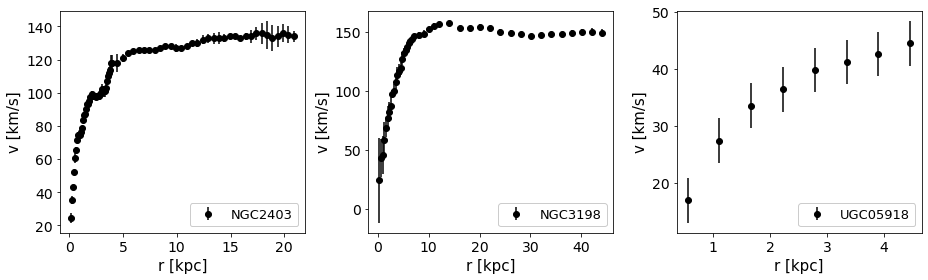

In [4]:
fig, axs = plt.subplots(1,3,figsize=(13,4))
for ii,ax in enumerate(axs):
    name = names_list[ii]
    ax.errorbar(data[name]['values']['Rad'], data[name]['values']['Vobs'], 
            yerr=data[name]['values']['errV'], label=f'{name}',
            c='k', ls=' ', marker='o')
    ax.set_xlabel('r [{}]'.format(data[name]['units']['Rad']), fontsize=15)
    ax.set_ylabel('v [{}]'.format(data[name]['units']['Vobs']), fontsize=15)
    legend = ax.legend(fontsize=13, loc=4)
    legend.get_frame().set_alpha(1)
    # ax.axis([-2,48,0,170])
    ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

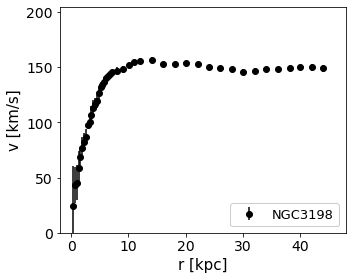

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.errorbar(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vobs'], 
            yerr=data['NGC3198']['values']['errV'], label='NGC3198',
            c='k', ls=' ', marker='o')
# ax.plot(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vgas'], label='gas',
#             c='C0', ls='-')
# ax.plot(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vdisk'], label='disk',
#             c='C1', ls='-')
# ax.plot(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vbul'], label='bulge',
#             c='C2', ls='-')
ax.set_xlabel('r [{}]'.format(data['NGC3198']['units']['Rad']), fontsize=15)
ax.set_ylabel('v [{}]'.format(data['NGC3198']['units']['Vobs']), fontsize=15)
legend = ax.legend(fontsize=13, loc=4)
legend.get_frame().set_alpha(1)
ax.axis([-2,48,0,205])
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

### Spherical system rotating under gravity
We can assume the galaxy to be a spherically symmetric system and estimate the tangential velocity at a distance $r$ from the centre as:

$v=\sqrt{\frac{GM(r)}{r}}$

In [6]:
def v_rotation(M, r=None):
    G = constants.G
    if r is None: r = 10**np.linspace(-1,1.5,50)
    try: Ms = M(r)
    except: Ms = M
    v = np.sqrt(G*Ms/r).to('km/s')
    return v

### Power-law model for the density profile 
We define a density profile as a power-law as:

$\rho(r)=\rho_0\left(\frac{r}{r_0}\right)^{-\eta}$ ,

where $\rho_0$ and $r_0$ are free parameters. $\eta$ is the power-law index that describes the radial ($r$) dependence. Using this density profile, we can calculate the mass $M(r)$ as:

$M(r) = \int^r_0 4\pi r^2 \rho(r) dr \Rightarrow M(r) = \frac{4\pi \rho_0 r_0^3}{3-\eta} \left(\frac{r}{r_0}\right)^{3-\eta}$ .

Putting the above relation into the equation for the rotating velocity, we get:

$v=\sqrt{\frac{4\pi \rho_0 r_0^2}{3-\eta} \left(\frac{r}{r_0}\right)^{2-\eta}} \Rightarrow v \propto r^{1-\eta/2}$ .

In [7]:
def rho_powerlaw(eta, rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    rho = lambda r: rho0*(r/r0)**(-eta)
    return rho(r)

def M_powerlaw(eta, rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    if eta==3: M = lambda r: 4*np.pi*rho0*r0**3
    else: M = lambda r: 4*np.pi*rho0*r0**3/(3-eta)*(r/r0)**(3-eta)
    return M(r).to('Msun')

def v_rotation_powerlaw(eta, rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)
    v = v_rotation(M_powerlaw(eta, rho0, r0, r=r), r=r)
    return v

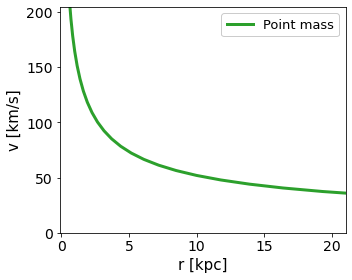

In [8]:
rho0 = 5e17*units.Msun/units.Mpc**3
r0   = 1*units.kpc
rr   = 10**np.linspace(-2,1.5,50)*units.kpc

fig, ax = plt.subplots(1,1,figsize=(5,4))
# eta  = 0 
# ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
#         lw=3, c='C0', label='Spherical disk'.format(eta))
eta  = 3
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C2', label='Point mass'.format(eta))
ax.set_xlabel('r [{}]'.format(data['NGC3198']['units']['Rad']), fontsize=15)
ax.set_ylabel('v [{}]'.format(data['NGC3198']['units']['Vobs']), fontsize=15)
legend = ax.legend(fontsize=13, loc=0)
legend.get_frame().set_alpha(1)
ax.axis([-0.1,21,0,205])
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

#### Exponential intensity of distribution in disk

An exponential radial dependence of the light is a reasonable description for disk galaxies: $\Sigma(r)=\Sigma_0e^{-\frac{r}{r_d}}$ .

The luminosity at radius $r$ can be derived as $L(r) = 2\pi\int^r_0 r I(r) dr$. We can estimate the mass of these visible (baryonic) matter as $M(r)=\Upsilon L(r)$.
The rotation curve for an infinitesimally thin exponential disk is expressed by ([Binney & Scott 1987](https://ui.adsabs.harvard.edu/abs/1987gady.book.....B/abstract); [Cimatti et al. 2020](https://ui.adsabs.harvard.edu/abs/2020igfe.book.....C/abstract)):

$v=\sqrt{4\pi G \Sigma_0 r_d y^2 [I_0(y)K_0(y)-I_1(y)K_1(y)]}$ ,

where $r_d$ is the radius of the disk and $y=r/(2r_d)$. $I_i$ and $K_i$ are the modified Bessel functions of the first and second, respectively, kind.

In [9]:
def v_rotation_exp_disk(v0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)
    y = r/(2*r0)
    v = v0*y*np.sqrt(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))
    return v

# def v_rotation_exp_disk(Sigma0, r0, r=None):
#     if r is None: r = 10**np.linspace(-1,1.5,50)
#     y = r/(2*r0)
#     G = constants.G
#     v0 = np.sqrt(4*G*Sigma0*r0)
#     v = v0*y*np.sqrt(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))
#     return v

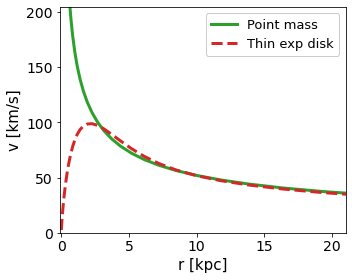

In [10]:
rho0 = 5e17*units.Msun/units.Mpc**3
r0   = 1*units.kpc
rr   = 10**np.linspace(-2,1.5,50)*units.kpc

fig, ax = plt.subplots(1,1,figsize=(5,4))
# ax.errorbar(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vobs'], 
#             yerr=data['NGC3198']['values']['errV'], label='NGC3198',
#             c='k', ls=' ', marker='o')
# eta  = 0 
# ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
#         lw=3, c='C0', label='Spherical disk'.format(eta))
eta  = 3
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C2', label='Point mass'.format(eta))
v0 = 225*units.km/units.s
ax.plot(rr, v_rotation_exp_disk(v0, r0, r=rr), 
        lw=3, c='C3', ls='--', label='Thin exp disk')
# ax.axvline(r0.value)
# ax.axvline(r0.value*2)
ax.set_xlabel('r [{}]'.format(data['NGC3198']['units']['Rad']), fontsize=15)
ax.set_ylabel('v [{}]'.format(data['NGC3198']['units']['Vobs']), fontsize=15)
legend = ax.legend(fontsize=13, loc=0)
legend.get_frame().set_alpha(1)
ax.axis([-0.1,21,0,205])
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

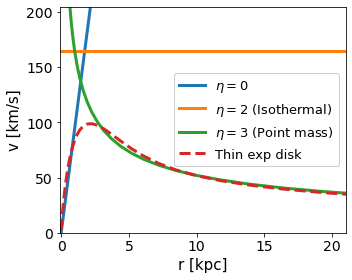

In [11]:
rho0 = 5e17*units.Msun/units.Mpc**3
r0   = 1*units.kpc
rr   = 10**np.linspace(-2,1.5,50)*units.kpc

fig, ax = plt.subplots(1,1,figsize=(5,4))
# ax.errorbar(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vobs'], 
#             yerr=data['NGC3198']['values']['errV'], label='NGC3198',
#             c='k', ls=' ', marker='o')
eta  = 0 
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C0', label='$\eta={}$'.format(eta))
# eta  = 1
# ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
#         lw=3, c='grey', label='$\eta={}$'.format(eta))
eta  = 2
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C1', label='$\eta={}$ (Isothermal)'.format(eta))
eta  = 3
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C2', label='$\eta={}$ (Point mass)'.format(eta))
v0 = 225*units.km/units.s
ax.plot(rr, v_rotation_exp_disk(v0, r0, r=rr), 
        lw=3, c='C3', ls='--', label='Thin exp disk')
ax.set_xlabel('r [{}]'.format(data['NGC3198']['units']['Rad']), fontsize=15)
ax.set_ylabel('v [{}]'.format(data['NGC3198']['units']['Vobs']), fontsize=15)
legend = ax.legend(fontsize=13, loc=0)
legend.get_frame().set_alpha(1)
ax.axis([-0.1,21,0,205])
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

### Modifications to density profiles that behaves better at small radius
We will try out the following cases:

1. $\rho(r)=\rho_0 e^{(r/r_0)}$
2. $\rho(r)=\rho_0 e^{-(r/r_0)^2}$
3. $\rho(r)=\frac{\rho_0}{1+(r/r_0)^{2}}$ ,

where $\rho_0$ and $r_0$ are free parameters. 

In [12]:
def rho_pseudo_isothermal(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    rho = lambda r: rho0/(1+(r/r0)**2)
    return rho(r)

def M_pseudo_isothermal(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    rho_Msun_per_Mpc3 = lambda x: rho_pseudo_isothermal(rho0, r0, r=x*units.Mpc).to('Msun/Mpc^3').value
    integ = lambda x: 4*np.pi*x**2*rho_Msun_per_Mpc3(x)
    M_Msun = np.vectorize(lambda x: quad(integ, 0, x)[0])
    r_Mpc = r.to('Mpc').value
    return M_Msun(r_Mpc)*units.Msun

def v_pseudo_isothermal(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)
    v = v_rotation(M_pseudo_isothermal(rho0, r0, r=r), r=r)
    return v

def rho_exp_rising(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    rho = lambda r: rho0*np.exp(r/r0)
    return rho(r)

def M_exp_rising(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    rho_Msun_per_Mpc3 = lambda x: rho_exp_rising(rho0, r0, r=x*units.Mpc).to('Msun/Mpc^3').value
    integ = lambda x: 4*np.pi*x**2*rho_Msun_per_Mpc3(x)
    M_Msun = np.vectorize(lambda x: quad(integ, 0, x)[0])
    r_Mpc = r.to('Mpc').value
    return M_Msun(r_Mpc)*units.Msun

def v_exp_rising(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)
    v = v_rotation(M_exp_rising(rho0, r0, r=r), r=r)
    return v

def rho_Gaussian_fall(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    rho = lambda r: rho0*np.exp(-(r/r0)**2)
    return rho(r)

def M_Gaussian_fall(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)*units.kpc
    rho_Msun_per_Mpc3 = lambda x: rho_Gaussian_fall(rho0, r0, r=x*units.Mpc).to('Msun/Mpc^3').value
    integ = lambda x: 4*np.pi*x**2*rho_Msun_per_Mpc3(x)
    M_Msun = np.vectorize(lambda x: quad(integ, 0, x)[0])
    r_Mpc = r.to('Mpc').value
    return M_Msun(r_Mpc)*units.Msun

def v_Gaussian_fall(rho0, r0, r=None):
    if r is None: r = 10**np.linspace(-1,1.5,50)
    v = v_rotation(M_Gaussian_fall(rho0, r0, r=r), r=r)
    return v

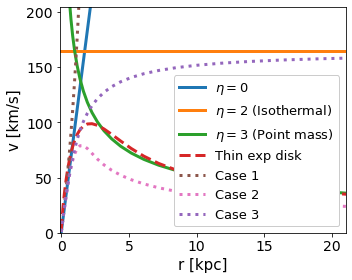

In [13]:
rho0 = 5e17*units.Msun/units.Mpc**3
r0   = 1*units.kpc
rr   = 10**np.linspace(-2,1.5,50)*units.kpc

fig, ax = plt.subplots(1,1,figsize=(5,4))
# ax.errorbar(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vobs'], 
#             yerr=data['NGC3198']['values']['errV'], label='NGC3198',
#             c='k', ls=' ', marker='o')
eta  = 0 
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C0', label='$\eta={}$'.format(eta))
eta  = 2
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C1', label='$\eta={}$ (Isothermal)'.format(eta))
eta  = 3
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C2', label='$\eta={}$ (Point mass)'.format(eta))
v0 = 225*units.km/units.s
ax.plot(rr, v_rotation_exp_disk(v0, r0, r=rr), 
        lw=3, c='C3', ls='--', label='Thin exp disk')

ax.plot(rr, v_exp_rising(rho0, r0, r=rr), 
        lw=3, c='C5', ls=':', label='Case 1')
ax.plot(rr, v_Gaussian_fall(rho0, r0, r=rr), 
        lw=3, c='C6', ls=':', label='Case 2')
ax.plot(rr, v_pseudo_isothermal(rho0, r0, r=rr), 
        lw=3, c='C4', ls=':', label='Case 3')
ax.set_xlabel('r [{}]'.format(data['NGC3198']['units']['Rad']), fontsize=15)
ax.set_ylabel('v [{}]'.format(data['NGC3198']['units']['Vobs']), fontsize=15)
legend = ax.legend(fontsize=13, loc=4)
legend.get_frame().set_alpha(1)
ax.axis([-0.1,21,0,205])
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

### Pseudo-isothermal density profile
The following density profile is well behaved at small radius:

$\rho(r)=\frac{\rho_0}{1+(r/r_0)^{2}}$ ,

where $\rho_0$ and $r_0$ are free parameters. At large radii ($r\gg r_0$), this density profile converges to $\rho \propto r^{-2}$, explaining the flat rotation curves.

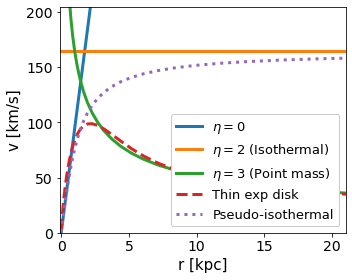

In [14]:
rho0 = 5e17*units.Msun/units.Mpc**3
r0   = 1*units.kpc
rr   = 10**np.linspace(-2,1.5,50)*units.kpc

fig, ax = plt.subplots(1,1,figsize=(5,4))
# ax.errorbar(data['NGC3198']['values']['Rad'], data['NGC3198']['values']['Vobs'], 
#             yerr=data['NGC3198']['values']['errV'], label='NGC3198',
#             c='k', ls=' ', marker='o')
eta  = 0 
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C0', label='$\eta={}$'.format(eta))
eta  = 2
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C1', label='$\eta={}$ (Isothermal)'.format(eta))
eta  = 3
ax.plot(rr, v_rotation_powerlaw(eta, rho0, r0, r=rr), 
        lw=3, c='C2', label='$\eta={}$ (Point mass)'.format(eta))
v0 = 225*units.km/units.s
ax.plot(rr, v_rotation_exp_disk(v0, r0, r=rr), 
        lw=3, c='C3', ls='--', label='Thin exp disk')
ax.plot(rr, v_pseudo_isothermal(rho0, r0, r=rr), 
        lw=3, c='C4', ls=':', label='Pseudo-isothermal')
ax.set_xlabel('r [{}]'.format(data['NGC3198']['units']['Rad']), fontsize=15)
ax.set_ylabel('v [{}]'.format(data['NGC3198']['units']['Vobs']), fontsize=15)
legend = ax.legend(fontsize=13, loc=4)
legend.get_frame().set_alpha(1)
ax.axis([-0.1,21,0,205])
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

### Model fitting: Least squared analysis

The rotational velocity of the total mass can be given as:

$f(r_i|\theta) = v^2=v^2_\mathrm{visible}+v^2_\mathrm{dark}$ ,

where $v_\mathrm{visible}$ and $v_\mathrm{dark}$ are velocities of visible and dark matter repsectively. Let us assume the visible matter to follow the thin exponential disk and dark matter to follow pseudo-isothermal distribution.

To find the best fit model parameters, we define weighted squared errors as the loss function:

$\mathcal{E} = \sum^N_i \left(\frac{y_i-f(x_i|\theta)}{\sigma^2_i}\right)^2$ .

The best fit model minimises this loss function. We will use the methods implemented in [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) for this purpose.

In [15]:
name = 'NGC3198'
    
# mins = np.array([10,0.5,11,0.5])
# maxs = np.array([500,50,21,50])
mins = np.array([10,-2,11,-2])
maxs = np.array([500,2,21,2])

def v_pseudo_isothermal_plus_exp_disk(vd, rd, rho0, r0, r):
    v_visible = v_rotation_exp_disk(vd, rd, r=r)
    v_dark = v_pseudo_isothermal(rho0, r0, r=r)
    v_tot = np.sqrt(v_visible**2+v_dark**2)
    return v_tot

def log_likelihood(theta):
    vd, logrd, logrho0, logr0 = theta
    rd = 10**logrd
    r0 = 10**logr0
    # vd, rd, logrho0, r0 = theta
    rho0 = 10**logrho0
    
    rho0 *= units.Msun/units.Mpc**3
    r0   *= units.kpc
    rd   *= units.kpc
    vd   *= units.km/units.s
    
    rr   = data[name]['values']['Rad']*units.kpc
    yy   = data[name]['values']['Vobs']*units.km/units.s
    yerr = data[name]['values']['errV']*units.km/units.s
    
    model = v_pseudo_isothermal_plus_exp_disk(vd, rd, rho0, r0, rr)
    sigma2 = yerr**2
    return -0.5 * np.sum((yy - model) ** 2 / sigma2)

def log_prior(theta):
    if mins[0] < theta[0] < maxs[0] and mins[1] < theta[1] < maxs[1] and mins[2] < theta[2] < maxs[2] and mins[3] < theta[3] < maxs[3]:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    if np.isnan(ll): return -np.inf
    return lp + ll

weighted_least_square_error = lambda *args: -log_probability(*args)

rho0 = 4e17*units.Msun/units.Mpc**3
r0   = 1*units.kpc
rr   = 10**np.linspace(-2,2,150)*units.kpc
rd   = 1*units.kpc
vd   = 225*units.km/units.s
theta = [225, -1, 17.6, -1]
print(weighted_least_square_error(theta))

68748.36497296972


In [16]:
np.random.seed(42)
initial = np.array([225, 1, 17.6, 1]) + 0.1 * np.random.randn(4)
soln = minimize(weighted_least_square_error, initial, args=())
# print(soln)

vd_ml, logrd_ml, logrho_ml, logr0_ml = soln.x
print(vd_ml, logrd_ml, logrho_ml, logr0_ml)

c:\Users\sutir\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\sutir\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


262.97912946247743 0.5864048912577117 16.29802570287239 0.6555270226954423


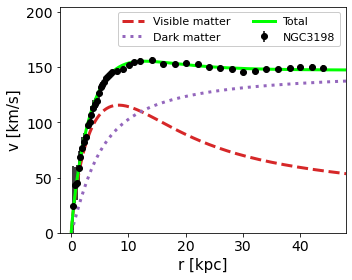

In [17]:
vd   = vd_ml*units.km/units.s
rd   = 10**logrd_ml*units.kpc
rr   = 10**np.linspace(-2,2,150)*units.kpc
rho0 = 10**logrho_ml*units.Msun/units.Mpc**3
r0   = 10**logr0_ml*units.kpc


fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.errorbar(data[name]['values']['Rad'], data[name]['values']['Vobs'], 
            yerr=data[name]['values']['errV'], label='NGC3198',
            c='k', ls=' ', marker='o')
ax.plot(rr, v_rotation_exp_disk(vd, rd, r=rr), 
        lw=3, c='C3', ls='--', label='Visible matter')
ax.plot(rr, v_pseudo_isothermal(rho0, r0, r=rr), 
        lw=3, c='C4', ls=':', label='Dark matter')
ax.plot(rr, np.sqrt(v_rotation_exp_disk(vd, rd, r=rr)**2+v_pseudo_isothermal(rho0, r0, r=rr)**2), 
        lw=3, c='lime', ls='-', label='Total')
ax.set_xlabel('r [{}]'.format(data[name]['units']['Rad']), fontsize=15)
ax.set_ylabel('v [{}]'.format(data[name]['units']['Vobs']), fontsize=15)
legend = ax.legend(fontsize=11, loc=0, ncol=2)
legend.get_frame().set_alpha(1)
ax.axis([-2,48,0,205])
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.show()

In [18]:
!pip install astroquery


HTTPError: Error 400: 
Cannot parse query '
SELECT TOP 1000
    a.source_id,
    a.ra,
    a.dec,
    a.teff_gspphot,
    a.logg_gspphot,
    a.vsini_gspphot,
    b.phot_g_mean_mag
FROM
    gaiadr3.astrophysical_parameters AS a
JOIN
    gaiadr3.gaia_source AS b
ON
    a.source_id = b.source_id
WHERE
    a.vsini_gspphot IS NOT NULL
ORDER BY
    a.vsini_gspphot DESC;
' for job '1718078756125O': 5 unresolved identifiers: ra [l.4 c.5 - l.4 c.9], dec [l.5 c.5 - l.5 c.10], vsini_gspphot [l.8 c.5 - l.8 c.20], vsini_gspphot [l.17 c.5 - l.17 c.20], vsini_gspphot [l.19 c.5 - l.19 c.20] !
 - Unknown column "a.ra" !
 - Unknown column "a.dec" !
 - Unknown column "a.vsini_gspphot" !
 - Unknown column "a.vsini_gspphot" !
 - Unknown column "a.vsini_gspphot" !
